# Neural Mass Model - BOLD SIGNAL CALCULATIONS
Olivia Beyer Bruvik <br> March 2021

In [1]:
%%bash 
cd /Users/oliviabeyerbruvik/Desktop/ei_hurst/code
pwd

#pip install ipynbname

/Users/oliviabeyerbruvik/Desktop/ei_hurst/code


In [31]:
# Add path to tools file
import sys, os
import ipynbname

nb_fname = ipynbname.name()
nb_path = ipynbname.path()
sys.path.insert(0, os.path.dirname(nb_fname))

#data_dir = '/Users/oliviabeyerbruvik/Desktop/colossus_test/' # parent directory of "Sim" directory
#data_dir = '/Users/oliviabeyerbruvik/Desktop/EI_hurst/Pablos_results/' # parent directory of "Sim" directory
#data_dir = '/Users/oliviabeyerbruvik/Desktop/EI_hurst/ei_hurst/results/'
#data_dir = '/Users/oliviabeyerbruvik/Desktop/'
data_dir = os.path.abspath(os.path.join(os.path.dirname(nb_fname), '..', 'results/'))

inhibitory_LFP = True

# External input rates
ext_rates = [2.0] # (spikes/s)

# File IDs
IDs = ["merged_files_Sim2_Sim3"]
#IDs = ["merged_files"] # To compute BOLD signal
#IDs = ["Sim4"] # synaptic conductances for excitatory and inhibitory
# IDs = ["Sim0_E_L","Sim1_E_L"] # Resting potential
# IDs = ["Sim0_Vth","Sim1_Vth"] # Spike threshold

added

Ext. rate = 2.0 sp/s, g_ex = 0.842105263158, g_in = 1.0, g = 13.409410112357872 

len(BOLD) = 400

Ext. rate = 2.0 sp/s, g_ex = 1.20394736842, g_in = 1.0, g = 9.3792595321504 

len(BOLD) = 400

Ext. rate = 2.0 sp/s, g_ex = 1.78289473684, g_in = 1.0, g = 6.333595920236343 

len(BOLD) = 400


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

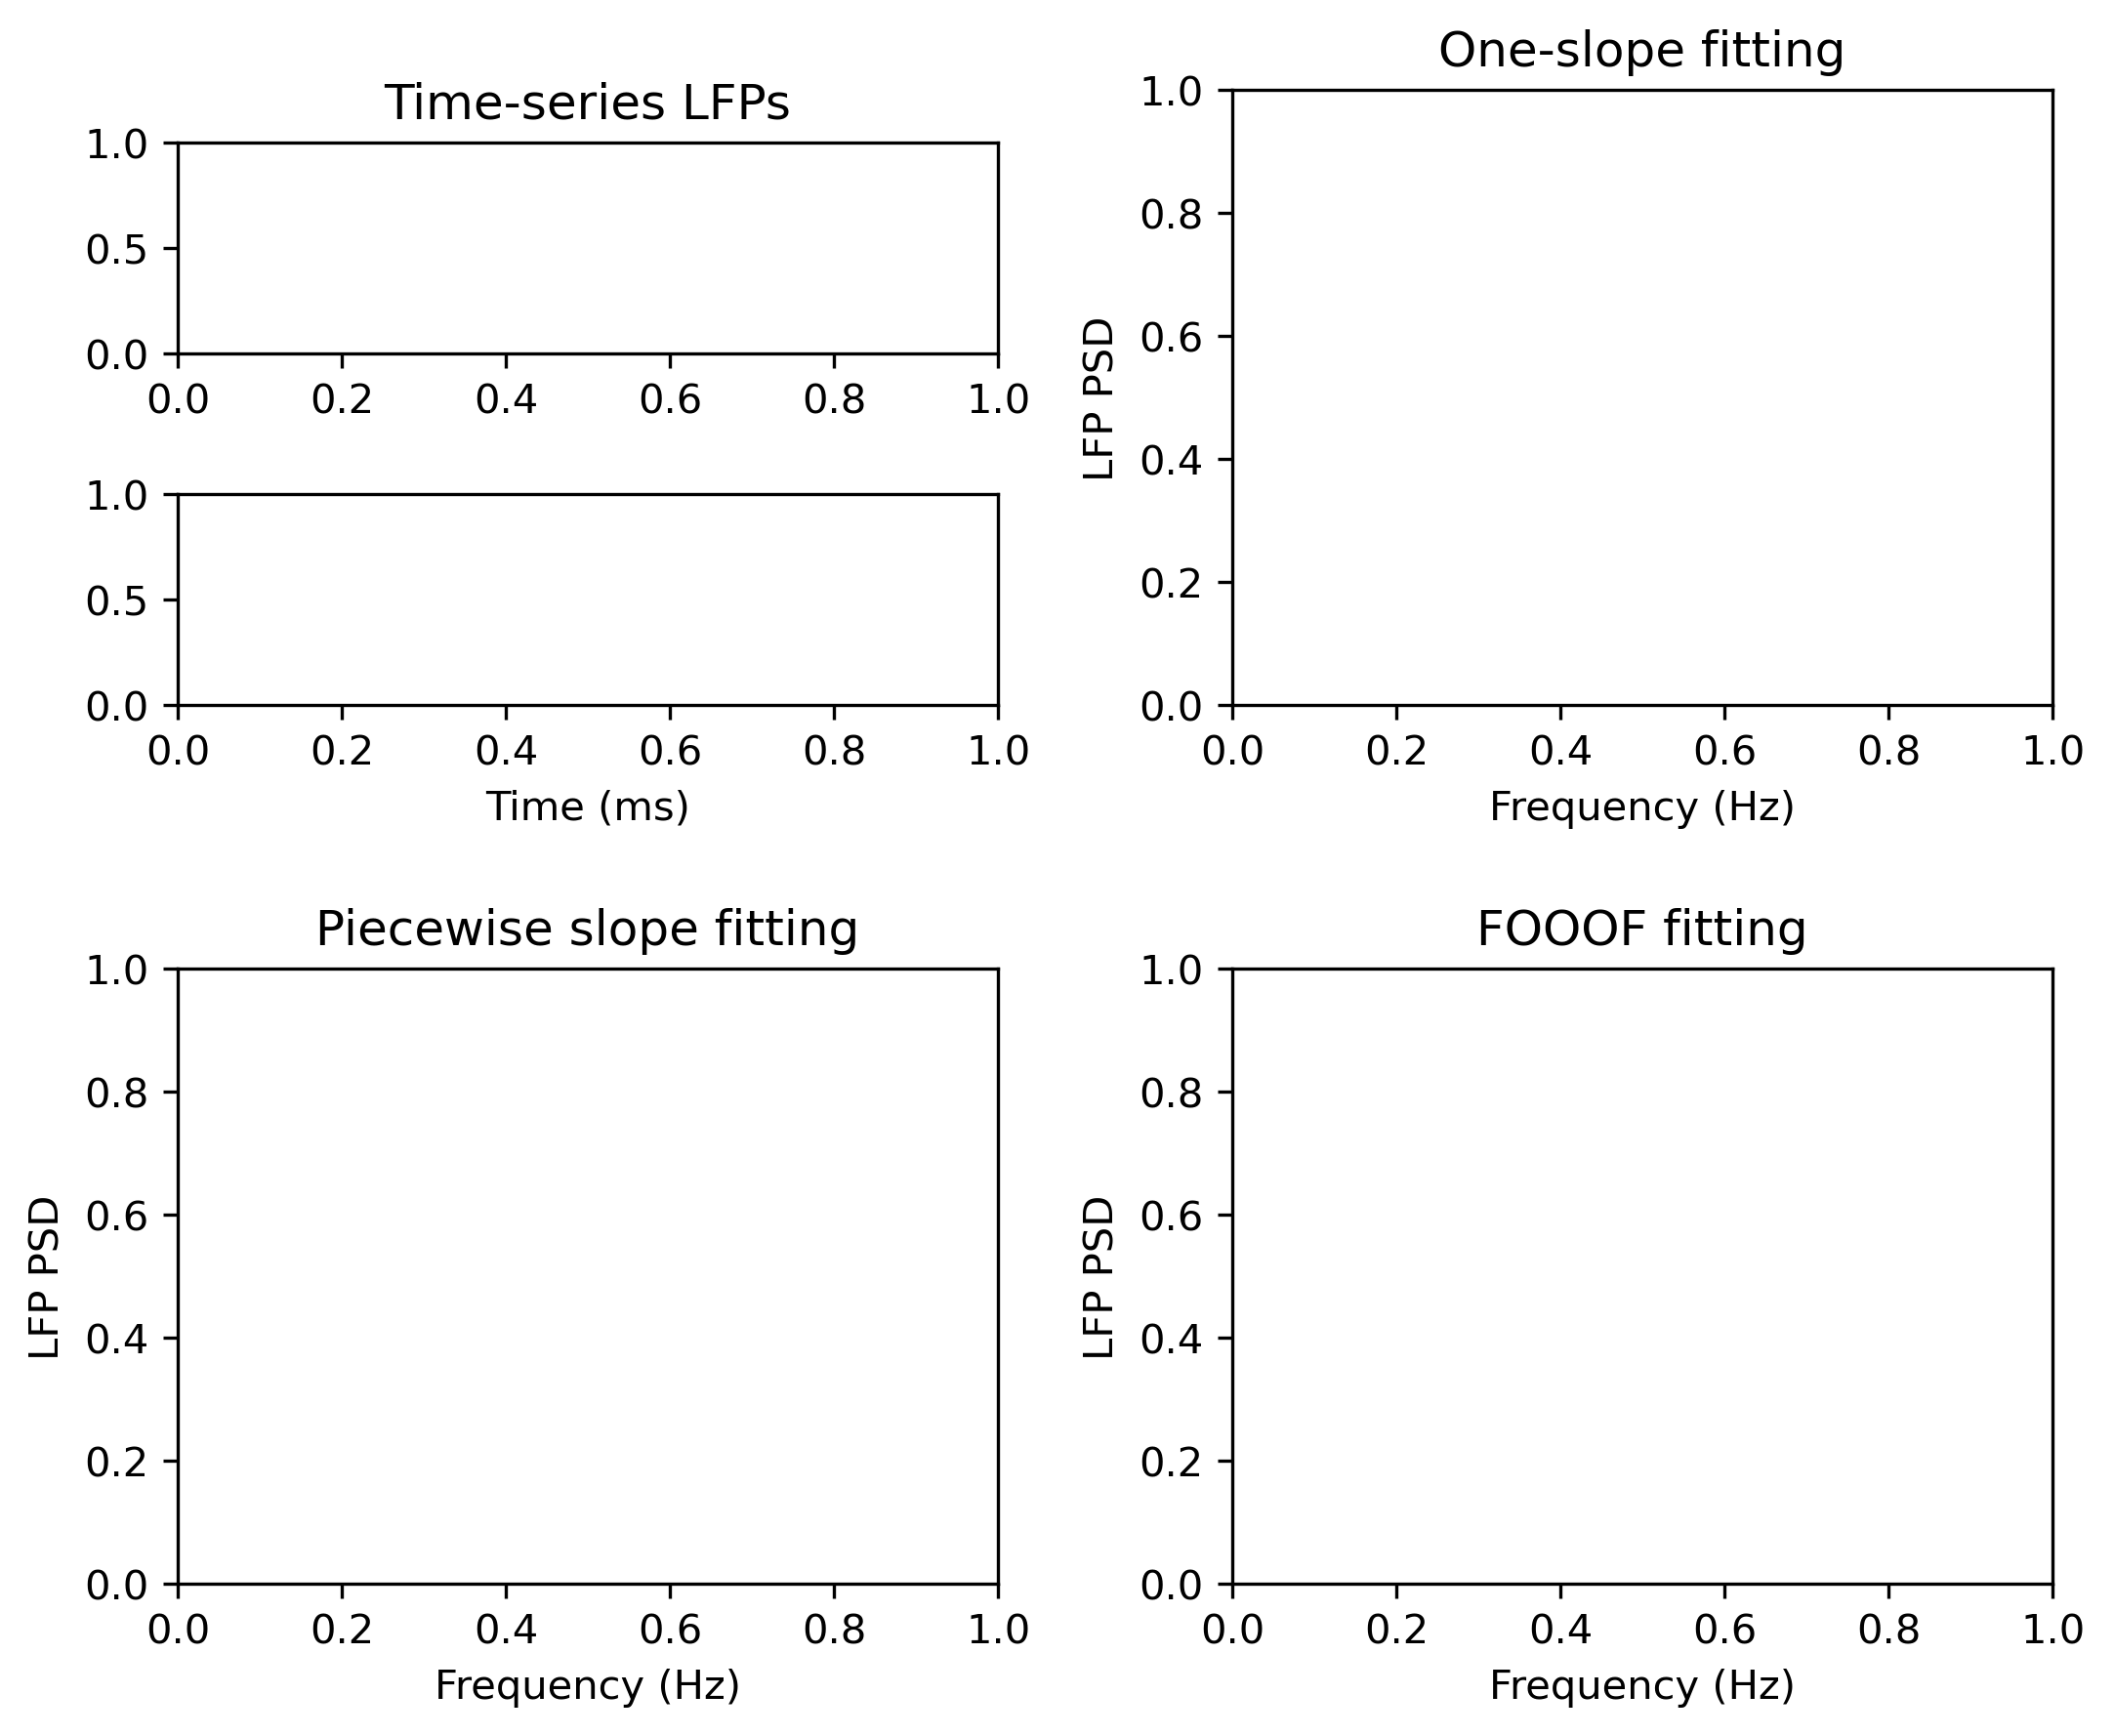

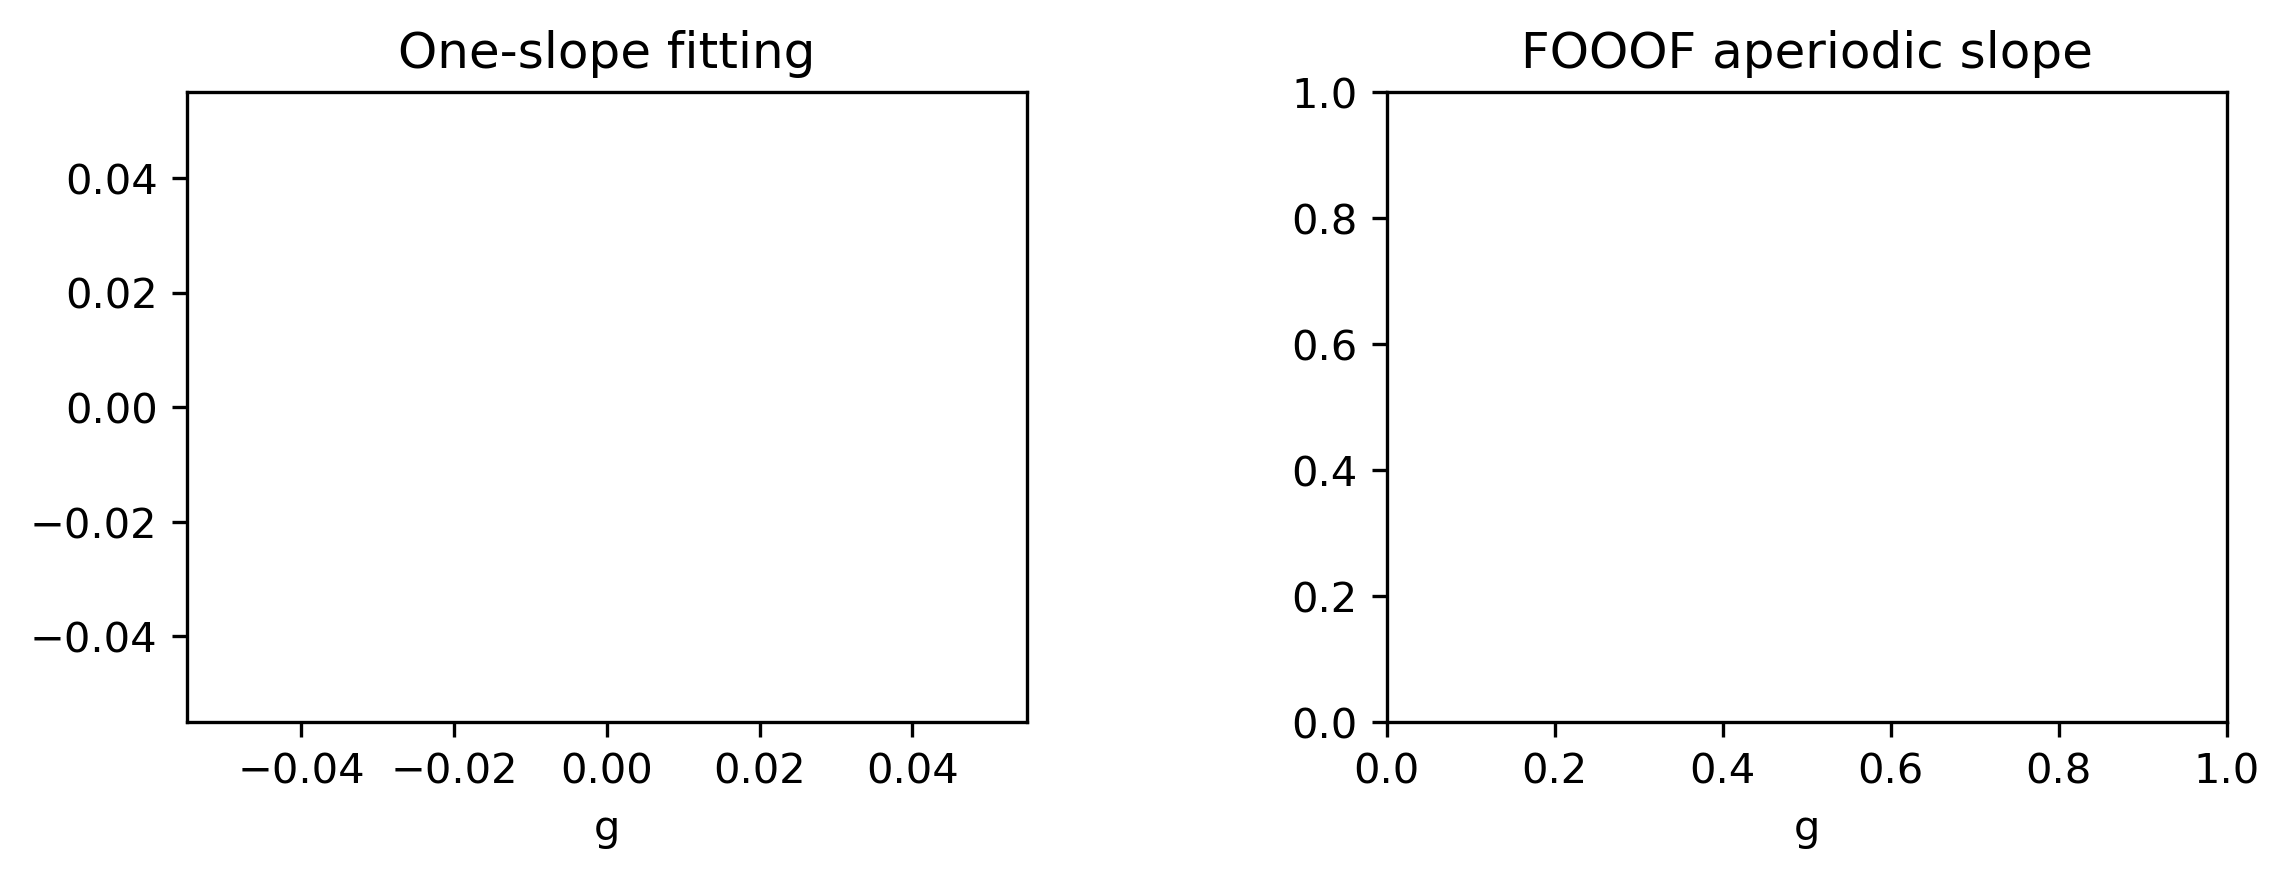

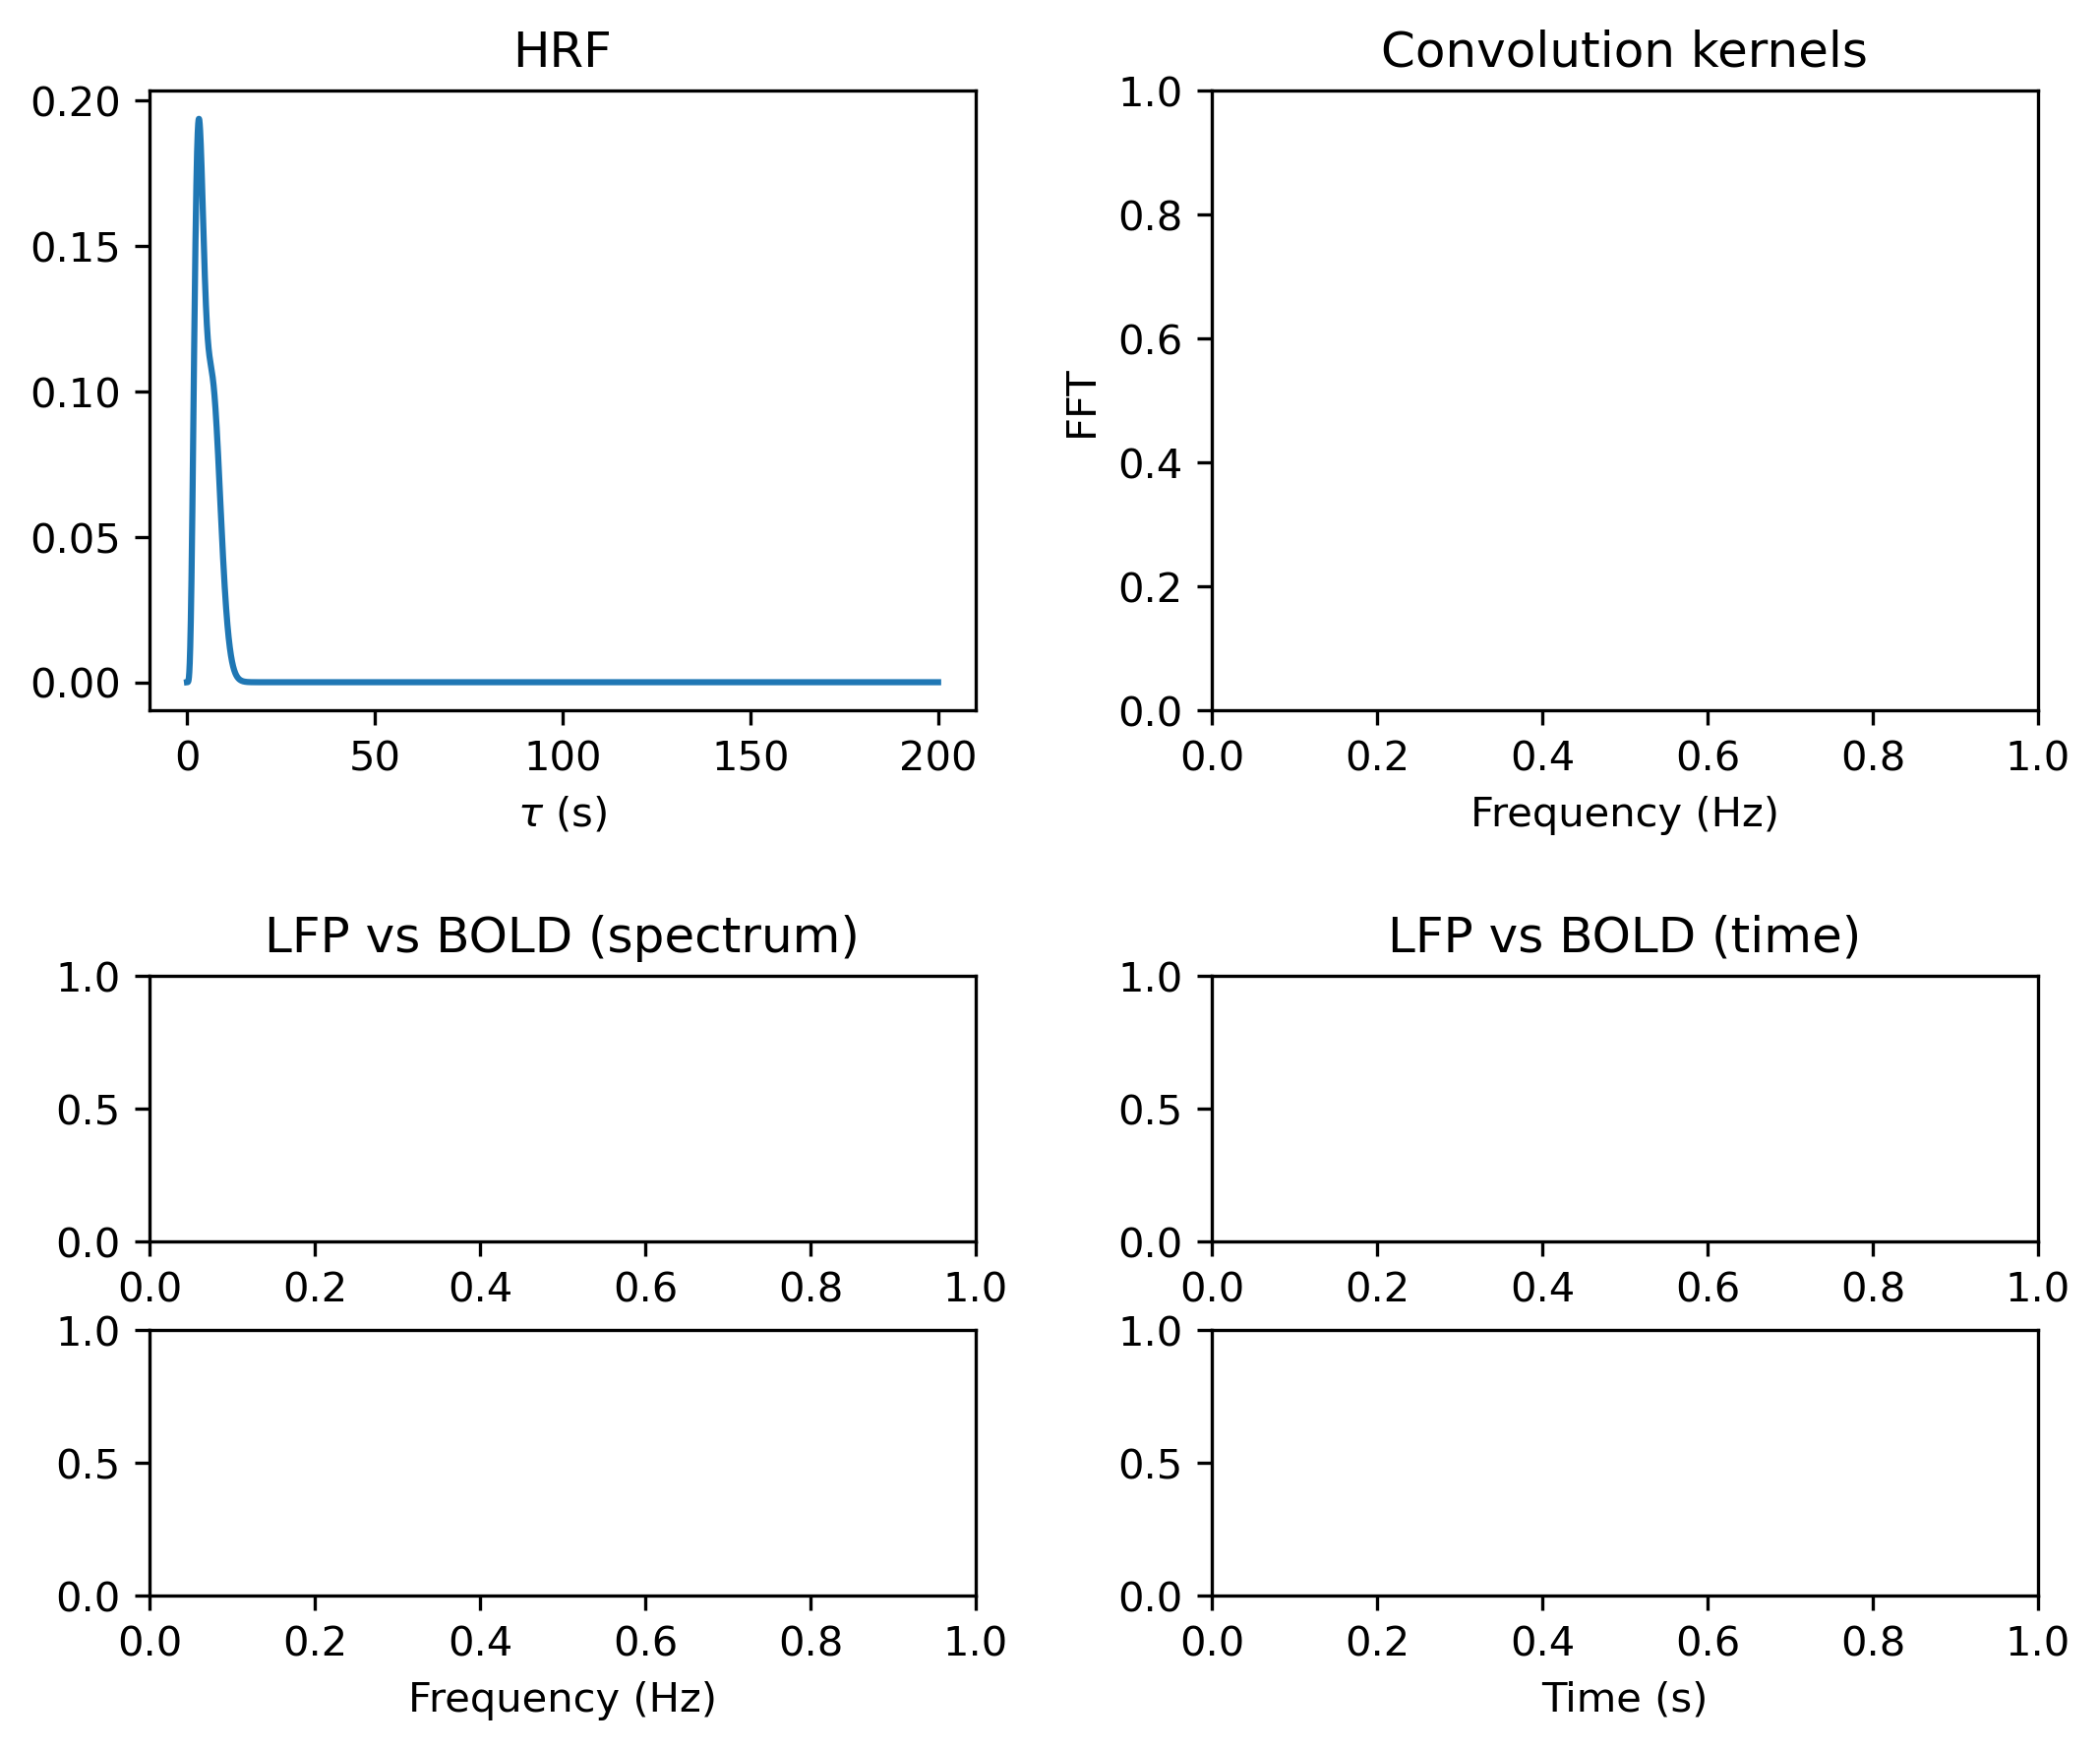

<Figure size 1800x1200 with 0 Axes>

In [32]:
###############################################################################
## Analysis of results from simulations of the recurrent network model.      ##
## Author: Pablo Martinez Canada (pablo.martinez@iit.it)                     ##
## Date: 08/04/2020                                                          ##
###############################################################################

import numpy as np
import sys,os
import cmath
import time
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy.stats
from scipy import optimize
from scipy.fftpack import fft,irfft
from scipy.signal import spectrogram
from scipy.ndimage.interpolation import shift
# from matplotlib import cm
# import pwlf # # piecewise linear regression
# import scipy.io as sio

# Import matlab engine to compute H
import matlab
import matlab.engine

# Import the FOOOF algorithm
from fooof import FOOOF

# Import tools
import tools

# Conductance values to calculate g
Network_params = {
    "exc_exc_recurrent": 0.178,
    "exc_inh_recurrent": 0.233,
    "inh_inh_recurrent": -2.70,
    "inh_exc_recurrent": -2.01
}

# Computation of LFP from synaptic currents
def LFP_est(AMPA_current,GABA_current,sim_step):
    # Sum of absolute values of AMPA and GABA PSCs
    I1 = np.abs(AMPA_current) + np.abs(GABA_current)
    # Normalize LFP
    # Discard first 500 ms for comp. mean and s. deviation
    start_time_pos = int(500.0/sim_step)
    I1 = (I1 - np.mean(I1[start_time_pos:])) / np.std(I1[start_time_pos:])
    return I1

# Manual piecewise linear regression with a fixed slpit
def piecewise_linear(x, y1,y2, k1, k2):
    fx0 = np.log10(30.0)
    return np.piecewise(x, [x < fx0], [lambda x:k1*x + y1, lambda x:k2*x + y2])

# Estimation of power spectral density using Welch’s method. We divided the data into
# 10 overlapping segments, with 50% overlap (default)
def powerSpectrum(signal,sim_step):
    return scipy.signal.welch(signal,fs = 1000./sim_step, nperseg = len(signal)/10.0 )

# Load the HRF
HRF = pickle.load(open(os.path.abspath(os.path.join(os.path.dirname(nb_fname), 'HRF')), "rb"),encoding='latin1')
# Downsample the HRF
HRF = tools.decimate(HRF,10)
# Pad with 0s
HRF = np.concatenate((HRF,HRF[-1]*np.ones(180000)))

# Plot Hurst exponent
plot_H = True

# Type of processing: either ratio of conductances (0) or chemogenetic
# manipulations (1)
proc_type = 0

# Number of trials
n_trials = 1

# Control variable for chemogenetic manipulations
# cont_var = "EL"
# label_var = r'$E_{L}$' + ' (mV)'
cont_var = "vth"
label_var = r'$V_{th}$' + ' (mV)'

# Baseline parameter
baseline = [11.3]

if proc_type == 0:
    label_var = 'g'
    cont_var = 'g'

# File IDs
#IDs = ["merged_files"] # To compute BOLD signal
#IDs = ["Sim1"] # synaptic conductances for excitatory and inhibitory
# IDs = ["Sim0_E_L","Sim1_E_L"] # Resting potential
# IDs = ["Sim0_Vth","Sim1_Vth"] # Spike threshold

# External input rates
#ext_rates = [2.0] # (spikes/s)

# Automatic search of values of g_ex and g_in, vth, EL from all files in folder
if proc_type == 0:
    g_ex_range = []
    g_in_range = []

cont_var_range = []

# Load all files
for id in IDs:
    if proc_type == 0:
        # Limits
        ## limits = [5,15.]
        limits = [3.5,15.]
        g_ex_range_aux = []
        g_in_range_aux = []
    else:
        cont_var_range_aux = []
        # Limits
        # limits = [-75.,-69.]
        limits = [-53.,-51.5]

    #dir = os.path.abspath(os.path.join(data_dir+id))
    dir = os.path.abspath(os.path.join(os.path.dirname(nb_fname), '..', 'results/'+id))
    ldir = os.listdir(dir)
    ldir.sort()

    for filename in ldir:
        #if 'AMPA' in filename:
        if '.AMPA' in filename:
            # g_ex
            if proc_type == 0:
                m1 = filename.find("gex_")+4
                m2 = filename.find("_gin_")
                g_ex = float(filename[m1:m2])

                # g_in
                m1 = filename.find("gin_")+4
                m2 = filename.find(".AMPA")
                g_in = float(filename[m1:m2])

                # Ext freq
                m1 = filename.find("rate_")+5
                m2 = filename.find("_gex")
                v0 = float(filename[m1:m2])

                g_ratio = -g_in*Network_params["inh_exc_recurrent"]/(g_ex*Network_params["exc_exc_recurrent"])
                if (g_ex == 1.0 or g_in == 1.0) and (v0 in ext_rates) and (g_ratio>= limits[0] and g_ratio <=limits[1]):
                    g_ex_range_aux.append(g_ex)
                    g_in_range_aux.append(g_in)

            else:
                # cont_var
                m1 = filename.find(cont_var+"_")+len(cont_var)+1
                m2 = filename.find(".AMPA")
                var = float(filename[m1:m2])

                # Ext freq
                m1 = filename.find("rate_")+5
                m2 = filename.find("_"+cont_var)
                v0 = float(filename[m1:m2])

                if v0 in ext_rates and (var>= limits[0] and var <=limits[1]):
                    cont_var_range_aux.append(var)


    # Select only unique values
    if proc_type == 0:
        g_ex_range_aux = np.array(g_ex_range_aux)
        g_in_range_aux = np.array(g_in_range_aux)

        g_ex_range_aux = np.unique(g_ex_range_aux)
        g_in_range_aux = np.unique(g_in_range_aux)

        # Add to g_ex_range and g_in_range
        g_ex_range.append(g_ex_range_aux)
        g_in_range.append(g_in_range_aux)
    else:
        cont_var_range_aux = np.array(cont_var_range_aux)
        cont_var_range_aux = np.unique(cont_var_range_aux)

        # Add to cont_var_range
        cont_var_range.append(cont_var_range_aux)

# For conductances, create a single array with all combinations
if proc_type == 0:
    for exp_cont,exp in enumerate(IDs):
        cont_var_range_aux = []

        for ggex in g_ex_range[exp_cont]:
            for ggin in g_in_range[exp_cont]:
                cont_var_range_aux.append([ggex,ggin])

        cont_var_range.append(cont_var_range_aux)

# 1/f slopes (LFPs)
all_slopes1 = []
all_var1 = []
all_slopes2 = []
all_var2 = []

# Slopes of piecewise linear regression (LFPs)
all_slopes1_pwlf_seg1 = []
all_slopes2_pwlf_seg1 = []
all_slopes1_pwlf_seg2 = []
all_slopes2_pwlf_seg2 = []

# Aperiodic parameters of FOOOF (LFPs)
all_ap_params1 = []
all_ap_params2 = []

# Hurst exponents (LFPs)
H_exponents_1_LFP = []
H_exponents_2_LFP = []
H_exponents_1_BOLD = []
H_exponents_2_BOLD = []

# Slopes of piecewise linear regression (BOLD signal)
all_slopes1_pwlf_seg1_BOLD = []
all_slopes2_pwlf_seg1_BOLD = []
all_slopes1_pwlf_seg2_BOLD = []
all_slopes2_pwlf_seg2_BOLD = []

# Correlation of LFP spectrogram and BOLD signal
Sxx_avg = []
Sxx_count = 0

# Plots
# Examples of LFP slope/FOOOF fitting
fig1 = plt.figure(figsize=[8,6], dpi=300)
# Summary of results of LFP slope fitting
fig2 = plt.figure(figsize=[8,6], dpi=300)
# BOLD kernels
fig3 = plt.figure(figsize=[8,6], dpi=300)
# Summary of results of H for LFP and BOLD
fig4 = plt.figure(figsize=[6,4], dpi=300)

# Properties of figure 1
Vax1_fig1 = fig1.add_axes([0.1,0.8,0.35,0.12],aspect='auto')
Vax2_fig1 = fig1.add_axes([0.1,0.6,0.35,0.12],aspect='auto')
Vax3_fig1 = fig1.add_axes([0.55,0.6,0.35,0.35],aspect='auto')
Vax4_fig1 = fig1.add_axes([0.1,0.1,0.35,0.35],aspect='auto')
Vax5_fig1 = fig1.add_axes([0.55,0.1,0.35,0.35],aspect='auto')

Vax1_fig1.set_title("Time-series LFPs")
Vax3_fig1.set_title("One-slope fitting")
Vax4_fig1.set_title("Piecewise slope fitting")
Vax5_fig1.set_title("FOOOF fitting")

Vax2_fig1.set_xlabel("Time (ms)")
Vax3_fig1.set_ylabel("LFP PSD")
Vax3_fig1.set_xlabel('Frequency (Hz)')
Vax4_fig1.set_ylabel("LFP PSD")
Vax4_fig1.set_xlabel('Frequency (Hz)')
Vax5_fig1.set_ylabel("LFP PSD")
Vax5_fig1.set_xlabel('Frequency (Hz)')

# Properties of figure 3
Vax1_fig3 = fig3.add_axes([0.1,0.6,0.35,0.35],aspect='auto')

Vax3_fig3 = fig3.add_axes([0.55,0.6,0.35,0.35],aspect='auto')

Vax4a_fig3 = fig3.add_axes([0.1,0.3,0.35,0.15],aspect='auto')
Vax4b_fig3 = fig3.add_axes([0.1,0.1,0.35,0.15],aspect='auto')

Vax5_fig3 = fig3.add_axes([0.55,0.3,0.35,0.15],aspect='auto')
Vax6_fig3 = fig3.add_axes([0.55,0.1,0.35,0.15],aspect='auto')

Vax1_fig3.set_title("HRF")
Vax3_fig3.set_title("Convolution kernels")
Vax4a_fig3.set_title("LFP vs BOLD (spectrum)")
Vax5_fig3.set_title("LFP vs BOLD (time)")

Vax1_fig3.set_xlabel("Time (s)")
Vax3_fig3.set_ylabel("FFT")
Vax3_fig3.set_xlabel('Frequency (Hz)')
Vax4b_fig3.set_xlabel('Frequency (Hz)')
Vax6_fig3.set_xlabel("Time (s)")

# Plot HRF
Vax1_fig3.set_xlabel(r'$\tau$'+' (s)')
t = np.arange(0.0,200.0,(1.0/1000.0))
Vax1_fig3.plot(t,HRF)

PSD_plot = 0
BOLD_plot = 0

# Select fast and slow LFPs to show
# g_selected = [5.646067415730337,14.79863985807809]
g_selected = [6.333595920236343,13.409410112357872]

# Start a new MATLAB process
if plot_H:
    eng = matlab.engine.start_matlab()

#eng.addpath('/Applications/MATLAB_R2020b.app/toolbox/wmtsa/dwt')
eng.addpath(os.path.abspath(os.path.join(os.path.dirname(nb_fname), 'dwt')))
eng.addpath(os.path.abspath(os.path.join(os.path.dirname(nb_fname), 'BWT_v2.0_fMRI_OSX10.9/BrainWavelet/third_party/wmtsa/dwt')))
eng.addpath(os.path.abspath(os.path.join(os.path.dirname(nb_fname), 'BWT_v2.0_fMRI_OSX10.9/BrainWavelet/third_party/wmtsa/utils')))
eng.addpath(os.path.abspath(os.path.join(os.path.dirname(nb_fname), 'EISlope-master/functions')))
eng.addpath(os.path.abspath(os.path.join(os.path.dirname(nb_fname), 'EISlope-master/scripts')))

print("added")

# Big loop
for ttrial in range(n_trials):
    # Rearrange LFP traces for the case with combined LFPs
    if IDs[0] == "merged_files":
        os.system('python3 merge_files.py')

    for exp_cont,exp in enumerate(IDs):
        all_LFPs = []
        for v0 in ext_rates:
            # PSD range for 1/f slope regression
            if v0 == 1.5:
                PSD_regression_range = [40.,70.] # Hz
            else:
                PSD_regression_range = [50., 80.] # Hz

            for var in cont_var_range[exp_cont]:
                # Select only g values within canonical axes
                if proc_type == 0:
                    if var[0]== 1. or var[1]== 1.:
                        # Print simulation case
                        var_ratio = -var[1]*Network_params["inh_exc_recurrent"]/(var[0]*Network_params["exc_exc_recurrent"])
                        print("\nExt. rate = %s sp/s, g_ex = %s, g_in = %s, g = %s \n" % (v0,var[0],var[1],var_ratio))
                        filename = 'trial_'+str(0)+'_rate_'+str(v0)+'_gex_'+\
                                    str(float("{0:.16f}".format(var[0])))+'_gin_'+str(float("{0:.16f}".format(var[1])))
                        continue_processing = True
                    else:
                        continue_processing = False
                else:
                    # Print simulation case
                    var_ratio = var
                    print("\nExt. rate = %s sp/s, variable = %s \n" % (v0,var))
                    filename = 'trial_'+str(0)+'_rate_'+str(v0)+'_'+cont_var+'_'+\
                                str(float("{0:.15f}".format(var)))
                    continue_processing = True

                # Load results
                if continue_processing:
                    try:
                        with open(data_dir+'/'+exp+'/'+filename+".AMPA", "rb") as f:
                            AMPA_current = pickle.load(open(data_dir+'/'+exp+'/'+filename+".AMPA", "rb"),encoding='latin1')
                            GABA_current = pickle.load(open(data_dir+'/'+exp+'/'+filename+".GABA", "rb"),encoding='latin1')
                            t_sim = pickle.load(open(data_dir+'/'+exp+'/'+filename+".times", "rb"),encoding='latin1')
                            simstep = pickle.load(open(data_dir+'/'+exp+'/'+filename+".dt", "rb"),encoding='latin1')
                            
                            if inhibitory_LFP:
                                in_AMPA_current = pickle.load(open(data_dir+'/'+exp+'/'+filename+".in_AMPA", "rb"),encoding='latin1')
                                in_GABA_current = pickle.load(open(data_dir+'/'+exp+'/'+filename+".in_GABA", "rb"),encoding='latin1')

                            # Downsample data
                            AMPA_current = tools.decimate(AMPA_current,10)
                            GABA_current = tools.decimate(GABA_current,10)
                            
                            t_sim = [t_sim[0][::10]]
                            simstep*=10.
                            
                            if inhibitory_LFP:
                                in_AMPA_current = tools.decimate(in_AMPA_current,10)
                                in_GABA_current = tools.decimate(in_GABA_current,10)

                            # LFP estimation
                            #I1 = LFP_est(AMPA_current,GABA_current,simstep)
                            I1 = 0.8 * LFP_est(AMPA_current,GABA_current,simstep) + 0.2 * LFP_est(in_AMPA_current,in_GABA_current,simstep)
                            I1 = np.concatenate((I1,[0]))

                            # Power spectral density of LFPs
                            fx1,PSD1 = powerSpectrum(I1,simstep)

                            # FFTs of LFPs
                            fft_LFP = np.fft.rfft(I1)
                            freq_fft_LFP = np.fft.rfftfreq(len(I1), d=simstep/1000.)

                            # Correct LFP spectra for low freq.
                            # Piecewise linear regression
                            pwlf_range = [np.where(freq_fft_LFP>=1.)[0][0], np.where(freq_fft_LFP>=99)[0][0]]
                            pp , ee = optimize.curve_fit(piecewise_linear, np.log10(freq_fft_LFP[pwlf_range[0]:pwlf_range[1]]),
                                                                         np.log10(np.abs(fft_LFP[pwlf_range[0]:pwlf_range[1]])))

                            surrogate_slopes = [pp[-2],pp[-1]]
                        

                            new_fft_LFP = fft_LFP.copy()

                            # Minimum freq. considered valid
                            min_freq_fft_LFP = freq_fft_LFP[np.where(freq_fft_LFP >= 1.)[0][0]]
                            min_fft_LFP = fft_LFP[np.where(freq_fft_LFP >= 1.)[0][0]]

                            # Extrapolate low freq.
                            for ffi,pbpf in enumerate(freq_fft_LFP):
                                if pbpf < min_freq_fft_LFP:
                                    ex_slope = surrogate_slopes[0]
                                    # # Random phase
                                    # fft_phase = np.exp(1j*np.random.uniform(0, 2*np.pi, (1)))
                                    # Same phase of the old FFT
                                    fft_phase = np.exp(1j*cmath.phase(fft_LFP[ffi]))

                                    # Freq. at 0 Hz
                                    if pbpf == 0:
                                        pbpf = freq_fft_LFP[1]

                                    fft_LFP_log_real = np.log10(np.abs(np.real(min_fft_LFP)))  - (np.log10(min_freq_fft_LFP) -\
                                                       np.log10(pbpf)) * ex_slope
                                    fft_LFP_log_imag = np.log10(np.abs(np.imag(min_fft_LFP)))  - (np.log10(min_freq_fft_LFP) -\
                                                       np.log10(pbpf)) * ex_slope

                                    new_fft_LFP[ffi] = np.abs(np.power(10,fft_LFP_log_real) + 1j * np.power(10,fft_LFP_log_imag)) * fft_phase


                            # # # Checkpoint
                            # figc = plt.figure(figsize=[8,4], dpi=300)
                            # Vax1 = figc.add_axes([0.15,0.15,0.75,0.75],aspect='auto')
                            # Vax1.loglog(freq_fft_LFP,np.abs(fft_LFP),
                            #           color = 'r',label = "Old LFP")
                            # Vax1.loglog(freq_fft_LFP,np.abs(new_fft_LFP),'--',
                            #           color = 'k',label = "new LFP")
                            #
                            # Vax1.loglog(freq_fft_LFP[1:2000],
                            #           np.power(10,piecewise_linear(np.log10(freq_fft_LFP[1:2000]),*pp)),
                            #           color = 'b',linestyle='--',linewidth=2.)
                            #
                            # Vax1.set_xlabel('Freq. (Hz)')
                            # Vax1.set_title('Extrapolated FFT')
                            # Vax1.legend()
                            # plt.show()

                            # Invert LFP spectrum
                            I1 = np.fft.irfft(new_fft_LFP,len(HRF))
                            fft_LFP = new_fft_LFP

                            # High-pass filter (HPF)
                            slope1 = 2
                            slope2 = 1.5
                            cutoff_freq1 = 0.03
                            cutoff_freq2 = 20

                            fft_HPF = np.ones(len(freq_fft_LFP)) * (0 + 0j)
                            cutoff_pos1 = np.where(freq_fft_LFP>=cutoff_freq1)[0][0]
                            cutoff_pos2 = np.where(freq_fft_LFP>=cutoff_freq2)[0][0]
                            
                            # First segment
                            for pbpf in np.arange(0,cutoff_pos1):
                                # fft_phase = np.exp(1j*0.5*np.pi)
                                fft_HPF[pbpf] = freq_fft_LFP[pbpf]*slope1

                            # Second segment
                            for pbpf in np.arange(cutoff_pos1-1,cutoff_pos2):
                                fft_HPF[pbpf] = np.power(freq_fft_LFP[pbpf],slope2) + fft_HPF[cutoff_pos1-1] -\
                                                np.power(freq_fft_LFP[cutoff_pos1-1],slope2)

                            # Plateau
                            for pbpf in np.arange(cutoff_pos2,len(freq_fft_LFP)):
                                fft_HPF[pbpf] = fft_HPF[cutoff_pos2-1]
                            
                            # Offset of the HPF
                            fft_HPF *= 10**(-2)
                            # HRF spectrum and offset
                            fft_HRF = np.fft.rfft(HRF)
                            fft_HRF*= 10**(-3)
                            
                            # White noise
                            fft_noise =10**(-5)*np.ones(len(fft_LFP))
                            
                             # BOLD signal
                            fft_BOLD = fft_LFP * (fft_HRF + fft_noise) * fft_HPF
                            # Offset
                            fft_BOLD *= 10**3

                            # Time-series of the BOLD signal
                            recovered_BOLD = np.fft.irfft(fft_BOLD, len(HRF))

                            # Downsample BOLD signal
                            BOLD_decimate = 500
                            recovered_BOLD = tools.decimate(recovered_BOLD,BOLD_decimate)
                            print("len(BOLD) = %s" % len(recovered_BOLD))

                            # Fig 3 plot
                            if proc_type == 0:
                                if (var_ratio in g_selected) and v0 == 1.5 and BOLD_plot < 2 and ttrial == 0:
                                    if BOLD_plot == 0:
                                        Vax3_fig3.loglog(freq_fft_LFP,np.abs((fft_HRF+fft_noise)),label = '(HRF+Noise)')
                                        Vax3_fig3.loglog(freq_fft_LFP,np.abs(fft_HPF),label = 'High-pass filter (HPF)')
                                        Vax3_fig3.loglog(freq_fft_LFP,np.abs(((fft_HRF+fft_noise) * fft_HPF )),label = '(HRF+Noise) * HPF')


                                    if var_ratio == g_selected[0]:
                                        Vax4a_fig3.loglog(freq_fft_LFP,np.abs(fft_LFP),linewidth=1.,
                                                         label = 'LFP')
                                        Vax4a_fig3.loglog(freq_fft_LFP,np.abs(fft_BOLD),linewidth=1.,
                                                         label = 'BOLD')
                                        Vax4a_fig3.set_ylabel(r'$g$'+" = "+str(float("{0:.2f}".format(var_ratio))))
                                    else:
                                        Vax4b_fig3.loglog(freq_fft_LFP,np.abs(fft_LFP),linewidth=1.,
                                                         label = 'LFP')
                                        Vax4b_fig3.loglog(freq_fft_LFP,np.abs(fft_BOLD),linewidth=1.,
                                                         label = 'BOLD')
                                        Vax4b_fig3.set_ylabel(r'$g$'+" = "+str(float("{0:.2f}".format(var_ratio))))


                                    Vax3_fig3.legend(loc='lower left')
                                    Vax4a_fig3.legend()
                                    Vax4b_fig3.legend()

                                    # LFPs
                                    time_interval = [4000,len(HRF)]
                                    if var_ratio == g_selected[0]:
                                        Vax5_fig3.plot(np.arange(time_interval[0]*simstep/1000.,time_interval[1]*simstep/1000.,simstep/1000.),
                                                       I1[time_interval[0]:time_interval[1]],
                                                       linewidth = 1.,color = 'b',label = 'LFP')
                                        Vax5_fig3.legend()
                                    else:
                                        Vax6_fig3.plot(np.arange(time_interval[0]*simstep/1000.,time_interval[1]*simstep/1000.,simstep/1000.),
                                                       I1[time_interval[0]:time_interval[1]],
                                                       linewidth = 1., color = 'b', label = 'LFP')
                                        Vax6_fig3.legend()

                                    # BOLDs
                                    max_BOLD = np.max(I1[time_interval[0]:time_interval[1]])/\
                                               np.max(recovered_BOLD[int(time_interval[0]/BOLD_decimate):int(time_interval[1]/BOLD_decimate)+1])
                                    if var_ratio == g_selected[0]:
                                        Vax5_fig3.plot(np.arange(time_interval[0]*simstep/1000.,time_interval[1]*simstep/1000.,BOLD_decimate*simstep/1000.),
                                                       recovered_BOLD[int(time_interval[0]/BOLD_decimate):int(time_interval[1]/BOLD_decimate)+1]*max_BOLD,
                                                       linewidth = 2.,color = 'k',label = 'BOLD')
                                        Vax5_fig3.legend()
                                        Vax5_fig3.set_ylabel(r'$g$'+" = "+str(float("{0:.2f}".format(var_ratio))))
                                    else:
                                        Vax6_fig3.plot(np.arange(time_interval[0]*simstep/1000.,time_interval[1]*simstep/1000.,BOLD_decimate*simstep/1000.),
                                                       recovered_BOLD[int(time_interval[0]/BOLD_decimate):int(time_interval[1]/BOLD_decimate)+1]*max_BOLD,
                                                       linewidth = 2.,color = 'k',label = 'BOLD')
                                        Vax6_fig3.legend()
                                        Vax6_fig3.set_ylabel(r'$g$'+" = "+str(float("{0:.2f}".format(var_ratio))))



                                    BOLD_plot+=1

                                    # Save HRF and kernel FFTs
                                    # df_HRF = pd.DataFrame({'time': np.arange(0,20,simstep*0.001),'HRF': HRF[0:20000]})
                                    #
                                    # PSD_range = [np.where(freq_fft_LFP>=0.03)[0][0], np.where(freq_fft_LFP>100)[0][0]]
                                    # df_fft_HRF = pd.DataFrame({'fx': freq_fft_LFP[PSD_range[0]:PSD_range[1]],
                                    #                           'PSD': np.abs(fft_HRF[PSD_range[0]:PSD_range[1]] + fft_noise[PSD_range[0]:PSD_range[1]])})
                                    # df_fft_HPF = pd.DataFrame({'fx': freq_fft_LFP[PSD_range[0]:PSD_range[1]],
                                    #                           'PSD': np.abs(fft_HPF[PSD_range[0]:PSD_range[1]])})
                                    #
                                    #
                                    # df_HRF.to_csv("../Figures_2/data_recurrent_network_model/HRF.csv")
                                    # df_fft_HRF.to_csv("../Figures_2/data_recurrent_network_model/fft_HRF.csv")
                                    # df_fft_HPF.to_csv("../Figures_2/data_recurrent_network_model/fft_HPF.csv")

                                    # # Save FFTs/time-series of BOLD
                                    # fft_BOLD_down = np.fft.rfft(recovered_BOLD)
                                    # freq_fft_BOLD_down = np.fft.rfftfreq(len(recovered_BOLD), d=BOLD_decimate*simstep/1000.)
                                    # PSD_range = [np.where(freq_fft_BOLD_down>=0)[0][0], np.where(freq_fft_BOLD_down>0.25)[0][0]]
                                    # fft_BOLD_down/=np.max(np.abs(fft_BOLD_down[PSD_range[0]:PSD_range[1]])) # normalize
                                    #
                                    # df_fft_BOLD = pd.DataFrame({'fx': freq_fft_BOLD_down[PSD_range[0]:PSD_range[1]],
                                    #                           'PSD': np.abs(fft_BOLD_down[PSD_range[0]:PSD_range[1]])})
                                    # df_fft_BOLD.to_csv("../Figures_2/data_recurrent_network_model/fft_BOLD_HPF_Yes_"+str(var_ratio)+".csv")
                                    #
                                    # df_BOLD = pd.DataFrame({'time':np.arange(10,150,BOLD_decimate/1000.),
                                    #              'BOLD':recovered_BOLD[int(10*(1000./BOLD_decimate)):int(150*(1000./BOLD_decimate))]/\
                                    #                     np.max(recovered_BOLD)})
                                    # df_BOLD.to_csv("../Figures_2/data_recurrent_network_model/BOLD_"+str(var_ratio)+".csv")
                                    #
                                    # # Compute LF to HF power ratio
                                    # LF_range = [np.where(freq_fft_BOLD_down>=0)[0][0], np.where(freq_fft_BOLD_down>0.1)[0][0]]
                                    # HF_range = [np.where(freq_fft_BOLD_down>=0.15)[0][0], np.where(freq_fft_BOLD_down>0.25)[0][0]]
                                    # LF_HF_ratio = np.trapz(np.abs(fft_BOLD_down[LF_range[0]:LF_range[1]]), x = freq_fft_BOLD_down[LF_range[0]:LF_range[1]])/\
                                    #               np.trapz(np.abs(fft_BOLD_down[HF_range[0]:HF_range[1]]), x = freq_fft_BOLD_down[HF_range[0]:HF_range[1]])
                                    # print("LF_HF_ratio = %s" % LF_HF_ratio)

                            # Correlation between BOLD signal and LFP
                            # Select a group of LFPs
                            if proc_type == 0 and v0 == 1.5 and var_ratio < 8:

                                # LFP spectrogram
                                fs = 1000.0/simstep
                                fxx, txx, Sxx = spectrogram(I1,fs,nperseg = BOLD_decimate,nfft = 500)

                                # # Plot LFP spectogram
                                # txx_end = np.where(txx >= 10.)[0][0]
                                # fxx_end = np.where(fxx >= 99)[0][0]
                                #
                                # figc = plt.figure(figsize=[6,4], dpi=300)
                                # Vax1 = figc.add_axes([0.1,0.15,0.35,0.7],aspect='auto')
                                # aaa = Vax1.pcolormesh(txx[0:txx_end], fxx[0:fxx_end], np.log10(Sxx[0:fxx_end,0:txx_end]),cmap = 'jet')
                                # figc.colorbar(aaa, ax = Vax1)
                                # Vax1.set_ylabel('Frequency [Hz]')
                                # Vax1.set_xlabel('Time (s)')
                                # Vax1.set_title("log(LFP spectogram)")
                                # Vax1.invert_yaxis()
                                #
                                # Vax2 = figc.add_axes([0.55,0.15,0.25,0.7])
                                # t_peak = np.where(txx>=4)[0][0]
                                # Vax2.plot(np.log10(Sxx[0:fxx_end,t_peak]),fxx[0:fxx_end],linewidth = 2.)
                                # Vax2.invert_yaxis()
                                # Vax2.set_xlabel('log(spectrum)')
                                # Vax2.set_yticks([])
                                # Vax2.set_title(r'$\tau= %s s$'%str(txx[t_peak]))
                                #
                                # plt.show()

                                # Adjust the BOLD signal to have the same length of Sxx (t)
                                downs_BOLD = np.zeros(len(txx))
                                time_BOLD = np.arange(0,len(I1)/1000,simstep*(BOLD_decimate/1000))

                                for ii,delay in enumerate(txx):
                                    pos_t = np.where(time_BOLD >= delay)[0]
                                    if len(pos_t) > 0:
                                        if pos_t[0] < len(recovered_BOLD):
                                            downs_BOLD[ii] = recovered_BOLD[pos_t[0]]
                                        else:
                                            downs_BOLD[ii] = recovered_BOLD[-1]

                                # Pearson correlation at different delays
                                corxx = np.zeros((Sxx.shape[0],Sxx.shape[1]))
                                for fk in range(len(fxx)):
                                    for delay in range(len(txx)):
                                        delayed_LFP = shift(Sxx[fk,:],delay,cval = 0)
                                        # delayed_LFP = np.roll(Sxx[fk,:],delay)
                                        corr_coeff = scipy.stats.pearsonr(delayed_LFP,downs_BOLD)[0]
                                        corxx[fk,delay] = corr_coeff

                                # Accumulate with previous results
                                if len(Sxx_avg) == 0:
                                    Sxx_avg = corxx.copy()
                                else:
                                    Sxx_avg += corxx
                                Sxx_count+=1

                            # Hurst exponent
                            if plot_H:
                                # Compute Hurst exponent of BOLD
                                x_vec = matlab.double(list(recovered_BOLD))
                                x_vec.reshape([len(recovered_BOLD),1])
                                H = eng.bfn_mfin_ml(x_vec, 'filter','haar', 'lb', matlab.double([-0.5,0]), 'ub', matlab.double([1.5,10]))

                                if v0 == 1.5:
                                    H_exponents_1_BOLD.append(H)
                                else:
                                    H_exponents_2_BOLD.append(H)

                                # if (var_ratio in g_selected) and v0 == 1.5 and BOLD_plot < 3:
                                #     sio.savemat('BOLD_'+str(BOLD_plot)+'.mat',{'BOLD_'+str(BOLD_plot):recovered_BOLD})
                                #     sio.savemat('H_BOLD_'+str(BOLD_plot)+'.mat',{'H_BOLD_'+str(BOLD_plot):H})

                                # Compute Hurst exponent of LFP
                                x_vec = matlab.double(list(I1))
                                x_vec.reshape([len(I1),1])
                                H = eng.bfn_mfin_ml(x_vec, 'filter','haar', 'lb', matlab.double([-0.5,0]), 'ub', matlab.double([1.5,10]))

                                if v0 == 1.5:
                                    H_exponents_1_LFP.append(H)
                                else:
                                    H_exponents_2_LFP.append(H)

                                # if (var_ratio in g_selected) and v0 == 1.5 and BOLD_plot < 3:
                                #     sio.savemat('LFP_'+str(BOLD_plot)+'.mat',{'LFP_'+str(BOLD_plot):I1})
                                #     sio.savemat('H_LFP_'+str(BOLD_plot)+'.mat',{'H_LFP_'+str(BOLD_plot):H})

                            # Initialize FOOOF
                            # fm = FOOOF(max_n_peaks = 1, peak_width_limits = [2.,100.], peak_threshold=2.50,aperiodic_mode='knee')
                            if v0 == 1.5:
                                fm = FOOOF(max_n_peaks = 3, peak_width_limits = [5.,99], peak_threshold=1.)
                            else:
                                ## fm = FOOOF(max_n_peaks = 3, peak_width_limits = [5.,99], peak_threshold=1.)
                                fm = FOOOF(max_n_peaks = 3, peak_width_limits = [3.5,99], peak_threshold=1.)

                            # Set the frequency range upon which to fit FOOOF
                            freq_range = [1, 99]

                            # Run FOOOF model
                            fm.fit(fx1, PSD1, freq_range)

                            # Gather all results
                            ap_params, peak_params, r_squared, fit_error, gauss_params = fm.get_results()

                            # Collect aperiodic results
                            if v0 == 1.5:
                                all_ap_params1.append(ap_params)
                            else:
                                all_ap_params2.append(ap_params)

                            # Least-squares regression of 1/f slope
                            regression_range = [np.where(fx1>PSD_regression_range[0])[0][0], np.where(fx1>PSD_regression_range[1])[0][0]]

                            slope1, intercept1, r_value1, p_value1,std_err1 = scipy.stats.linregress(np.log10(fx1[regression_range[0]:regression_range[1]]),
                                                                      np.log10(PSD1[regression_range[0]:regression_range[1]]))

                            # Collect 1/f slopes
                            if v0 == 1.5:
                                all_slopes1.append(slope1)
                                all_var1.append(var_ratio)
                            else:
                                all_slopes2.append(slope1)
                                all_var2.append(var_ratio)

                            # Piecewise linear regression
                            # Initialize piecewise linear fit with your x and y data
                            pwlf_range = [np.where(fx1>=1.)[0][0], np.where(fx1>99)[0][0]]
                            # my_pwlf = pwlf.PiecewiseLinFit(np.log10(fx1[pwlf_range[0]:pwlf_range[1]]),
                            #                                np.log10(PSD1[pwlf_range[0]:pwlf_range[1]]))
                            # # fit the data for two line segments
                            # res = my_pwlf.fit(2)
                            #
                            # # Get the slopes
                            # my_slopes = my_pwlf.slopes

                            # Manual piecewise linear regression
                            pp , ee = optimize.curve_fit(piecewise_linear, np.log10(fx1[pwlf_range[0]:pwlf_range[1]]),
                                                                         np.log10(PSD1[pwlf_range[0]:pwlf_range[1]]))

                            my_slopes = [pp[-2],pp[-1]]

                            # Collect low- and high- freq. slopes
                            if v0 == 1.5:
                                all_slopes1_pwlf_seg1.append(my_slopes[0])
                                all_slopes1_pwlf_seg2.append(my_slopes[1])
                            else:
                                all_slopes2_pwlf_seg1.append(my_slopes[0])
                                all_slopes2_pwlf_seg2.append(my_slopes[1])

                            # Save LFPs, power spectra, slopes and FOOOF results
                            # if proc_type == 0:
                            #     if (var_ratio in g_selected) and v0 == 2 and ttrial == 0:
                            #         time_interval = [np.where(t_sim[0]>1000.)[0][0],
                            #                          np.where(t_sim[0]>6000.)[0][0]]
                            #
                            #         df_LFP = pd.DataFrame({'time': np.arange(1000,6000,simstep),'LFP': I1[time_interval[0]:time_interval[1]]})
                            #
                            #         PSD_range = [np.where(fx1>=1)[0][0], np.where(fx1>100)[0][0]]
                            #         df_PSD = pd.DataFrame({'fx': fx1[PSD_range[0]:PSD_range[1]],'PSD': PSD1[PSD_range[0]:PSD_range[1]]})
                            #
                            #         PSD_range_s1 = [np.where(fx1>=1)[0][0], np.where(fx1>29)[0][0]]
                            #         PSD_range_s2 = [np.where(fx1>30)[0][0], np.where(fx1>100)[0][0]]
                            #
                            #         df_slope_1 = pd.DataFrame({'fx': fx1[PSD_range_s1[0]:PSD_range_s1[1]],
                            #             'PSD': np.power(10,piecewise_linear(np.log10(fx1[PSD_range_s1[0]:PSD_range_s1[1]]),*pp))})
                            #         df_slope_2 = pd.DataFrame({'fx': fx1[PSD_range_s2[0]:PSD_range_s2[1]],
                            #             'PSD': np.power(10,piecewise_linear(np.log10(fx1[PSD_range_s2[0]:PSD_range_s2[1]]),*pp))})
                            #
                            #         # FOOOF fitting
                            #         if len(ap_params) == 3:
                            #             ap_fit = np.power(10,ap_params[0])*1./(ap_params[1] + np.power(fx1,ap_params[2]))
                            #         else:
                            #             ap_fit = np.power(10,ap_params[0])*1./(np.power(fx1,ap_params[1]))
                            #
                            #
                            #         # Plot periodic+aperiodic fit
                            #         ys = np.zeros_like(fx1)
                            #         for ii in gauss_params:
                            #             ctr, hgt, wid = ii
                            #             ys = ys + hgt * np.exp(-(fx1-ctr)**2 / (2*wid**2))
                            #
                            #         sum_signal = np.power(10,ys)*ap_fit
                            #
                            #         df_fooof = pd.DataFrame({'fx': fx1[PSD_range[0]:PSD_range[1]],
                            #                                  'PSD': sum_signal[PSD_range[0]:PSD_range[1]]})
                            #
                            #         # df_LFP.to_csv("../Figures_2/data_recurrent_network_model/LFP_"+str(var_ratio)+".csv")
                            #         # df_PSD.to_csv("../Figures_2/data_recurrent_network_model/PSD_"+str(var_ratio)+".csv")
                            #         # df_slope_1.to_csv("../Figures_2/data_recurrent_network_model/PSD_slope_1_"+str(var_ratio)+".csv")
                            #         # df_slope_2.to_csv("../Figures_2/data_recurrent_network_model/PSD_slope_2_"+str(var_ratio)+".csv")
                            #
                            #         df_PSD.to_csv("../Figures_2/data_recurrent_network_model/PSD_2_"+str(var_ratio)+".csv")
                            #         df_fooof.to_csv("../Figures_2/data_recurrent_network_model/fooof_"+str(var_ratio)+".csv")


                            # Fig 1 plot
                            if proc_type == 0:
                                if (var_ratio in g_selected) and v0 == 1.5 and PSD_plot < 2 and ttrial == 0:

                                    # LFP
                                    time_interval = [np.where(t_sim[0]>1000.)[0][0],
                                                     np.where(t_sim[0]>6000.)[0][0]]
                                    if var_ratio == g_selected[0]:
                                        Vax1_fig1.plot(np.arange(1000,6000,simstep),I1[time_interval[0]:time_interval[1]],
                                                       linewidth = 1.5,color = 'b',label = r'$g$'+" = "+str(float("{0:.2f}".format(var_ratio))))
                                        Vax1_fig1.legend()
                                    else:
                                        Vax2_fig1.plot(np.arange(1000,6000,simstep),I1[time_interval[0]:time_interval[1]],
                                                       linewidth = 1.5, color = 'b', label = r'$g$'+" = "+str(float("{0:.2f}".format(var_ratio))))
                                        Vax2_fig1.legend()

                                    # PSDs
                                    PSD_range = [np.where(fx1>=5.)[0][0], np.where(fx1>99)[0][0]]
                                    Vax3_fig1.loglog(fx1[PSD_range[0]:PSD_range[1]],PSD1[PSD_range[0]:PSD_range[1]],
                                                 linewidth=3.,alpha = 0.3,label = r'$g$'+" = "+str(float("{0:.2f}".format(var_ratio))))
                                    Vax4_fig1.loglog(fx1[PSD_range[0]:PSD_range[1]],PSD1[PSD_range[0]:PSD_range[1]],
                                                 linewidth=3.,alpha = 0.3,label = r'$g$'+" = "+str(float("{0:.2f}".format(var_ratio))))
                                    Vax5_fig1.loglog(fx1[PSD_range[0]:PSD_range[1]],PSD1[PSD_range[0]:PSD_range[1]],
                                                  linewidth=3.,alpha = 0.3,label = r'$g$'+" = "+str(float("{0:.2f}".format(var_ratio))))

                                    # 1/f fitting
                                    ff = np.arange(PSD_regression_range[0],PSD_regression_range[1],1.)
                                    Vax3_fig1.loglog(ff,np.power(10, slope1*np.log10(ff) + intercept1),
                                              color = 'k',linewidth=1.)

                                    # Piecewise fitting
                                    PSD_range_s1 = [np.where(fx1>=5.)[0][0], np.where(fx1>29.)[0][0]]
                                    PSD_range_s2 = [np.where(fx1>30.)[0][0], np.where(fx1>99)[0][0]]
                                    Vax4_fig1.loglog(fx1[PSD_range_s1[0]:PSD_range_s1[1]],
                                              np.power(10,piecewise_linear(np.log10(fx1[PSD_range_s1[0]:PSD_range_s1[1]]),*pp)),
                                              color = 'k',linestyle='--',linewidth=1.)
                                    Vax4_fig1.loglog(fx1[PSD_range_s2[0]:PSD_range_s2[1]],
                                          np.power(10,piecewise_linear(np.log10(fx1[PSD_range_s2[0]:PSD_range_s2[1]]),*pp)),
                                          color = 'k',linestyle='--',linewidth=1.)

                                    # FOOOF fitting
                                    if len(ap_params) == 3:
                                        ap_fit = np.power(10,ap_params[0])*1./(ap_params[1] + np.power(fx1,ap_params[2]))
                                    else:
                                        ap_fit = np.power(10,ap_params[0])*1./(np.power(fx1,ap_params[1]))


                                    # Plot periodic+aperiodic fit
                                    ys = np.zeros_like(fx1)
                                    for ii in gauss_params:
                                        ctr, hgt, wid = ii
                                        ys = ys + hgt * np.exp(-(fx1-ctr)**2 / (2*wid**2))

                                    sum_signal = np.power(10,ys)*ap_fit

                                    Vax5_fig1.loglog(fx1[PSD_range[0]:PSD_range[1]],sum_signal[PSD_range[0]:PSD_range[1]],
                                                 color = 'k',linestyle='-.',linewidth=1.)

                                    # Legends
                                    Vax3_fig1.legend()
                                    Vax4_fig1.legend()
                                    Vax5_fig1.legend()

                                    PSD_plot += 1

                                
                    # Catch exception
                    except Exception as e:
                        exc_type, exc_obj, exc_tb = sys.exc_info()
                        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
                        print(exc_type, fname, exc_tb.tb_lineno)

# # H of BOLD
if plot_H:
    if ext_rates == [1.5, 2.0]:
        df1 = pd.DataFrame({'Simulation': [IDs[0]] * len(all_var1), 'Inhibitory LFP included?': [inhibitory_LFP] * len(all_var1), 'External input rate': [1.5] * len(all_var1), 'g_in/g_ex ratio': all_var1, 'Hurst exponent from BOLD signal': H_exponents_1_BOLD})
        df2 = pd.DataFrame({'Simulation': [IDs[0]] * len(all_var2), 'Inhibitory LFP included?': [inhibitory_LFP] * len(all_var2), 'External input rate': [2.0] * len(all_var2), 'g_in/g_ex ratio': all_var2, 'Hurst exponent from BOLD signal': H_exponents_2_BOLD})
        df = df2.append(df2)
    
    if ext_rates == [2.0]:
        df = pd.DataFrame({'Simulation': [IDs[0]] * len(all_var2), 'Inhibitory LFP included?': [inhibitory_LFP] * len(all_var2), 'External input rate': [2.0] * len(all_var2), 'g_in/g_ex ratio': all_var2, 'Hurst exponent from BOLD signal': H_exponents_2_BOLD})
        
        
    if os.path.isfile(os.path.abspath(os.path.join(os.path.dirname(nb_fname), '../data/recurrent_model/BOLD_H_g_values.csv'))):
        df.to_csv(os.path.abspath(os.path.join(os.path.dirname(nb_fname), '../data/recurrent_model/BOLD_H_g_values.csv')), mode='a', header=False)
    else:
        df.to_csv(os.path.abspath(os.path.join(os.path.dirname(nb_fname), '../data/recurrent_model/BOLD_H_g_values.csv')))

            
        
    #df = pd.DataFrame({'Simulation': [IDs[0]] * len(all_var2), 'Inhibitory LFP included?': inhibitory_LFP * len(all_var2), 'External input rate': [ext_rates[0]] * len(all_var2), 'g_in/g_ex ratio': all_var2, 'Hurst exponent from BOLD signal': H_exponents_2_BOLD})
    #if os.path.isfile(os.path.abspath(os.path.join(os.path.dirname(nb_fname), '../data/recurrent_model/BOLD_H_g_rate_2.0_Can_kernel_Yes_HPF.csv'))):
    #    df.to_csv(os.path.abspath(os.path.join(os.path.dirname(nb_fname), '../data/recurrent_model/BOLD_H_g_rate_2.0_Can_kernel_Yes_HPF.csv')), mode='a', header=False)
    #else:
     #   df.to_csv(os.path.abspath(os.path.join(os.path.dirname(nb_fname), '../data/recurrent_model/BOLD_H_g_rate_2.0_Can_kernel_Yes_HPF.csv')))

# Transform to numpy array
all_ap_params1 = np.array(all_ap_params1)*-1
all_ap_params2 = np.array(all_ap_params2)*-1

# plot summary of 1/f slopes and FOOOF algorithm
Vax1 = fig2.add_axes([0.1,0.6,0.35,0.35])
Vax2 = fig2.add_axes([0.6,0.6,0.35,0.35])
Vax1.set_xlabel(label_var)
Vax2.set_xlabel(label_var)
Vax1.set_title('One-slope fitting')
Vax2.set_title('FOOOF aperiodic slope')

Vax1.plot(all_var1,all_slopes1,'o',color = 'orange',label = '1.5 sp/s')
Vax2.plot(all_var1,all_ap_params1[:,-1],'o',color = 'orange')

Vax1.plot(all_var2,all_slopes2,'o',color = 'b',label = '2 sp/s')
Vax2.plot(all_var2,all_ap_params2[:,-1],'o',color = 'b')

# Baseline
Vax1.plot([baseline,baseline],[np.min(all_slopes2),np.max(all_slopes1)],linestyle = '--',linewidth = 1., color = 'k')
Vax2.plot([baseline,baseline],[np.min(all_ap_params1[:,-1]),np.max(all_ap_params2[:,-1])],linestyle = '--',linewidth = 1., color = 'k')

# Fit polys
z1 = np.polyfit(all_var1, all_slopes1, 2)
p1 = np.poly1d(z1)

z2 = np.polyfit(all_var1, all_ap_params1[:,-1], 2)
p2 = np.poly1d(z2)

z3 = np.polyfit(all_var2, all_slopes2, 2)
p3 = np.poly1d(z3)

z4 = np.polyfit(all_var2, all_ap_params2[:,-1], 2)
p4 = np.poly1d(z4)

all_var1_sorted = np.sort(all_var1)
all_var2_sorted = np.sort(all_var2)
Vax1.plot(all_var1_sorted,p1(all_var1_sorted),"k")
Vax2.plot(all_var1_sorted,p2(all_var1_sorted),"k")
Vax1.plot(all_var2_sorted,p3(all_var2_sorted),"k")
Vax2.plot(all_var2_sorted,p4(all_var2_sorted),"k")

Vax1.invert_xaxis()
Vax2.invert_xaxis()

Vax1.legend()

# plot summary of the piecewise linear fit
Vax1 = fig2.add_axes([0.1,0.1,0.35,0.35])
Vax2 = fig2.add_axes([0.6,0.1,0.35,0.35])
Vax1.set_xlabel(label_var)
Vax2.set_xlabel(label_var)
Vax1.set_title('Piecewise (low-fr. slope)')
Vax2.set_title('Piecewise (high-fr. slope)')

Vax1.plot(all_var1,all_slopes1_pwlf_seg1,'o',color = 'orange')
Vax2.plot(all_var1,all_slopes1_pwlf_seg2,'o',color = 'orange')

Vax1.plot(all_var2,all_slopes2_pwlf_seg1,'o',color = 'b')
Vax2.plot(all_var2,all_slopes2_pwlf_seg2,'o',color = 'b')

# Baseline
Vax1.plot([baseline,baseline],[np.min(all_slopes1_pwlf_seg1),np.max(all_slopes2_pwlf_seg1)],linestyle = '--',linewidth = 1., color = 'k')
Vax2.plot([baseline,baseline],[np.min(all_slopes1_pwlf_seg2),np.max(all_slopes2_pwlf_seg2)],linestyle = '--',linewidth = 1., color = 'k')

# Fit polys
z1 = np.polyfit(all_var1, all_slopes1_pwlf_seg1, 2)
p1 = np.poly1d(z1)

z2 = np.polyfit(all_var1, all_slopes1_pwlf_seg2, 2)
p2 = np.poly1d(z2)

z3 = np.polyfit(all_var2, all_slopes2_pwlf_seg1, 2)
p3 = np.poly1d(z3)

z4 = np.polyfit(all_var2, all_slopes2_pwlf_seg2, 2)
p4 = np.poly1d(z4)

Vax1.plot(all_var1_sorted,p1(all_var1_sorted),"k")
Vax2.plot(all_var1_sorted,p2(all_var1_sorted),"k")
Vax1.plot(all_var2_sorted,p3(all_var2_sorted),"k")
Vax2.plot(all_var2_sorted,p4(all_var2_sorted),"k")

Vax1.invert_xaxis()
Vax2.invert_xaxis()

# Plot H exponent
if plot_H:
    Vax1 = fig4.add_axes([0.1,0.15,0.4,0.75])
    Vax2 = fig4.add_axes([0.58,0.15,0.4,0.75])
    # Vax1.set_ylim([1.0,1.7])
    # Vax2.set_ylim([1.0,1.7])

    Vax1.set_xlabel(label_var)
    Vax1.set_title('H (LFP)')

    Vax2.set_xlabel(label_var)
    Vax2.set_title('H (BOLD)')

    Vax2.plot(all_var1,H_exponents_1_BOLD,'o',color = 'orange')
    Vax2.plot(all_var2,H_exponents_2_BOLD,'o',color = 'b')
    Vax1.plot(all_var1,H_exponents_1_LFP,'o',color = 'orange')
    Vax1.plot(all_var2,H_exponents_2_LFP,'o',color = 'b')

    # Baseline
    Vax1.plot([baseline,baseline],[1.0,2.0],linestyle = '--',linewidth = 1., color = 'k')
    Vax2.plot([baseline,baseline],[1.0,2.0],linestyle = '--',linewidth = 1., color = 'k')

    # Fit polys
    z1 = np.polyfit(all_var1, H_exponents_1_BOLD, 2)
    p1 = np.poly1d(z1)

    z3 = np.polyfit(all_var2, H_exponents_2_BOLD, 2)
    p3 = np.poly1d(z3)

    Vax2.plot(all_var1_sorted,p1(all_var1_sorted),"k")
    Vax2.plot(all_var2_sorted,p3(all_var2_sorted),"k")

    Vax2.invert_xaxis()

    # Fit polys
    z1 = np.polyfit(all_var1, H_exponents_1_LFP, 2)
    p1 = np.poly1d(z1)

    z3 = np.polyfit(all_var2, H_exponents_2_LFP, 2)
    p3 = np.poly1d(z3)

    Vax1.plot(all_var1_sorted,p1(all_var1_sorted),"k")
    Vax1.plot(all_var2_sorted,p3(all_var2_sorted),"k")

    Vax1.invert_xaxis()


# Plot Correlation results
# Time and freq. limits
txx_end = np.where(txx >= 7)[0][0]
fxx_end = np.where(fxx >= 100)[0][0]

# Spectogram of correlation
figc = plt.figure(figsize=[8,4], dpi=300)
Vax1 = figc.add_axes([0.06,0.15,0.35,0.75],aspect='auto')
aaa = Vax1.pcolormesh(txx[0:txx_end], fxx[0:fxx_end], Sxx_avg[0:fxx_end,0:txx_end]/(Sxx_count),cmap = 'jet')
figc.colorbar(aaa, ax = Vax1)
Vax1.set_ylabel('Frequency [Hz]')
Vax1.set_xlabel(r'$\tau$'+' (s)')
Vax1.set_title("Correlation (LFP power,BOLD)")
Vax1.invert_yaxis()

Vax2 = figc.add_axes([0.46,0.15,0.1,0.75])
t_peak = np.where(txx>=3.5)[0][0]
Vax2.plot(Sxx_avg[0:fxx_end,t_peak]/(Sxx_count),fxx[0:fxx_end],linewidth = 2.)
Vax2.invert_yaxis()
Vax2.set_xlabel('Correlation')
Vax2.set_yticks([])
Vax2.set_xticks([])
Vax2.set_title(r'$\tau= %s s$'%str(txx[t_peak]))

Vax3 = figc.add_axes([0.65,0.15,0.3,0.75])
Vax3.set_title('Correlation in freq. bands')
Vax3.set_xlabel(r'$\tau$'+' (s)')
# Vax3.set_ylim([-0.1,0.3])

# Plot correlation in freq. bands
LFP_bands = [[8,12],[15,30],[40,100],[0,100]]
labels = ['alpha','beta','gamma','LFP']
colors = ['g','r','b','grey']

for band in range(len(LFP_bands)):
    lowcut = LFP_bands[band][0]
    highcut = LFP_bands[band][1]
    fxx_range = [np.where(fxx >= lowcut)[0][0],np.where(fxx >= highcut)[0][0]]
    Vax3.plot(txx[0:txx_end:1],np.mean(Sxx_avg[fxx_range[0]:fxx_range[1],0:txx_end:1],axis = 0)/(Sxx_count),
              color = colors[band],label = labels[band])

    # # Save correlation in freq. bands
    # df_cor_band = pd.DataFrame({'time': txx[0:txx_end:1],
    #                             'band': np.mean(Sxx_avg[fxx_range[0]:fxx_range[1],0:txx_end:1],axis = 0)/(Sxx_count)})
    # df_cor_band.to_csv("../Figures_2/data_recurrent_network_model/"+labels[band]+"_band_Can_kernel_Yes_HPF.csv")

Vax3.legend()

# # Save correlation spectogram
# X, Y = np.meshgrid(txx[0:txx_end],fxx[0:fxx_end])
# Z = (Sxx_avg[0:fxx_end,0:txx_end]).flatten() / (Sxx_count)
# df_cor_matrix = pd.DataFrame({'X':X.flatten(),'Y':Y.flatten(),'Z':Z})
# df_cor_matrix.to_csv("../Figures_2/data_recurrent_network_model/corr_matrix_Can_kernel_Yes_HPF.csv")

## Save Slopes
# # Export data to CSV
# df = pd.DataFrame({'var': all_var1,'metric': all_slopes1_pwlf_seg1})
# df.to_csv("../Figures_2/data_recurrent_network_model/lf_slopes_"+cont_var+"_rate_"+str(1.5)+".csv")
# df = pd.DataFrame({'var': all_var2,'metric': all_slopes2_pwlf_seg1})
# df.to_csv("../Figures_2/data_recurrent_network_model/lf_slopes_"+cont_var+"_rate_"+str(2.0)+".csv")
#
# df = pd.DataFrame({'var': all_var1,'metric': all_slopes1_pwlf_seg2})
# df.to_csv("../Figures_2/data_recurrent_network_model/hf_slopes_"+cont_var+"_rate_"+str(1.5)+".csv")
# df = pd.DataFrame({'var': all_var2,'metric': all_slopes2_pwlf_seg2})
# df.to_csv("../Figures_2/data_recurrent_network_model/hf_slopes_"+cont_var+"_rate_"+str(2.0)+".csv")
#

# df = pd.DataFrame({'var': all_var1,'metric': all_ap_params1[:,-1]})
# df.to_csv("../Figures_2/data_recurrent_network_model/fooof_ap_"+cont_var+"_rate_"+str(1.5)+".csv")
# df = pd.DataFrame({'var': all_var2,'metric': all_ap_params2[:,-1]})
# df.to_csv("../Figures_2/data_recurrent_network_model/fooof_ap_"+cont_var+"_rate_"+str(2.0)+".csv")

# if plot_H:
#     df = pd.DataFrame({'var': all_var1,'metric': H_exponents_1_LFP})
#     df.to_csv("../Figures_2/data_recurrent_network_model/LFP_H_"+cont_var+"_rate_"+str(1.5)+".csv")
#     df = pd.DataFrame({'var': all_var2,'metric': H_exponents_2_LFP})
#     df.to_csv("../Figures_2/data_recurrent_network_model/LFP_H_"+cont_var+"_rate_"+str(2.0)+".csv")

# # H of BOLD
# if plot_H:
    # df = pd.DataFrame({'var': all_var1,'metric': H_exponents_1_BOLD})
    # df.to_csv("../Figures_2/data_recurrent_network_model/BOLD_H_g_rate_"+str(1.5)+"_Can_kernel_Yes_HPF.csv")
    # df = pd.DataFrame({'var': all_var2,'metric': H_exponents_2_BOLD})
    # df.to_csv("../Figures_2/data_recurrent_network_model/BOLD_H_g_rate_"+str(2.0)+"_Can_kernel_Yes_HPF.csv")

#plt.show()
